# Credit Card Fraud Detection using Anomaly Detection

## Overview
In this notebook, I'll implement multiple anomaly detection algorithms to identify fraudulent credit card transactions. Credit card fraud detection is a classic anomaly detection problem where fraudulent transactions represent a tiny fraction of all transactions, making it perfect for unsupervised anomaly detection techniques.

## Dataset
I'll use the Credit Card Fraud Detection dataset, which contains 284,807 transactions made by European cardholders in September 2013. The dataset is highly imbalanced with only 0.172% fraudulent transactions.

### Features:
- **V1-V28**: Principal components obtained through PCA transformation (anonymized for privacy)
- **Time**: Seconds elapsed between each transaction and the first transaction
- **Amount**: Transaction amount
- **Class**: Target variable (0 = legitimate, 1 = fraudulent)

## Approach
1. **Data Exploration**: Understand the dataset characteristics and class imbalance
2. **Preprocessing**: Scale features and handle the time component
3. **Multiple Algorithms**: Implement various anomaly detection methods
4. **Evaluation**: Compare performance using appropriate metrics for imbalanced data
5. **Visualization**: Create comprehensive visualizations of results


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Anomaly detection algorithms
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN

# Preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           precision_recall_curve, roc_curve, roc_auc_score,
                           average_precision_score, precision_score, recall_score,
                           f1_score, accuracy_score)

# Dimensionality reduction for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set style for visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")


All libraries imported successfully!


## 1. Data Loading and Exploration

Let me load the credit card dataset and examine its structure, distribution, and characteristics.


In [2]:
# Load the credit card dataset
print("Loading credit card dataset...")
df = pd.read_csv('../datasets/creditcard.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic information about the dataset
print(f"\n=== DATASET OVERVIEW ===")
print(f"Total transactions: {len(df):,}")
print(f"Number of features: {df.shape[1]}")
print(f"Data types:")
print(df.dtypes.value_counts())

print(f"\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found!")

# Display first few rows
print(f"\n=== FIRST FEW ROWS ===")
df.head()


Loading credit card dataset...
Dataset loaded successfully!
Dataset shape: (284807, 31)
Memory usage: 67.36 MB

=== DATASET OVERVIEW ===
Total transactions: 284,807
Number of features: 31
Data types:
float64    30
int64       1
Name: count, dtype: int64

=== MISSING VALUES ===
Total missing values: 0
No missing values found!

=== FIRST FEW ROWS ===


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Analyze class distribution (fraud vs legitimate)
print("=== CLASS DISTRIBUTION ANALYSIS ===")
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print(f"Legitimate transactions (Class 0): {class_counts[0]:,} ({class_percentages[0]:.3f}%)")
print(f"Fraudulent transactions (Class 1): {class_counts[1]:,} ({class_percentages[1]:.3f}%)")
print(f"Fraud rate: 1 in {int(1/class_percentages[1]*100)} transactions")

# Analyze transaction amounts
print(f"\n=== TRANSACTION AMOUNT ANALYSIS ===")
legitimate_amounts = df[df['Class'] == 0]['Amount']
fraudulent_amounts = df[df['Class'] == 1]['Amount']

print(f"Legitimate transactions:")
print(f"  Mean: ${legitimate_amounts.mean():.2f}")
print(f"  Median: ${legitimate_amounts.median():.2f}")
print(f"  Std: ${legitimate_amounts.std():.2f}")
print(f"  Max: ${legitimate_amounts.max():.2f}")

print(f"\nFraudulent transactions:")
print(f"  Mean: ${fraudulent_amounts.mean():.2f}")
print(f"  Median: ${fraudulent_amounts.median():.2f}")
print(f"  Std: ${fraudulent_amounts.std():.2f}")
print(f"  Max: ${fraudulent_amounts.max():.2f}")

# Analyze time distribution
print(f"\n=== TIME ANALYSIS ===")
print(f"Time range: {df['Time'].min():.0f} to {df['Time'].max():.0f} seconds")
print(f"Duration: {(df['Time'].max() - df['Time'].min()) / 3600:.1f} hours")
print(f"Time span: {(df['Time'].max() - df['Time'].min()) / (24*3600):.1f} days")

# Basic statistics for all features
print(f"\n=== FEATURE STATISTICS ===")
df.describe()


=== CLASS DISTRIBUTION ANALYSIS ===
Legitimate transactions (Class 0): 284,315 (99.827%)
Fraudulent transactions (Class 1): 492 (0.173%)
Fraud rate: 1 in 578 transactions

=== TRANSACTION AMOUNT ANALYSIS ===
Legitimate transactions:
  Mean: $88.29
  Median: $22.00
  Std: $250.11
  Max: $25691.16

Fraudulent transactions:
  Mean: $122.21
  Median: $9.25
  Std: $256.68
  Max: $2125.87

=== TIME ANALYSIS ===
Time range: 0 to 172792 seconds
Duration: 48.0 hours
Time span: 2.0 days

=== FEATURE STATISTICS ===


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


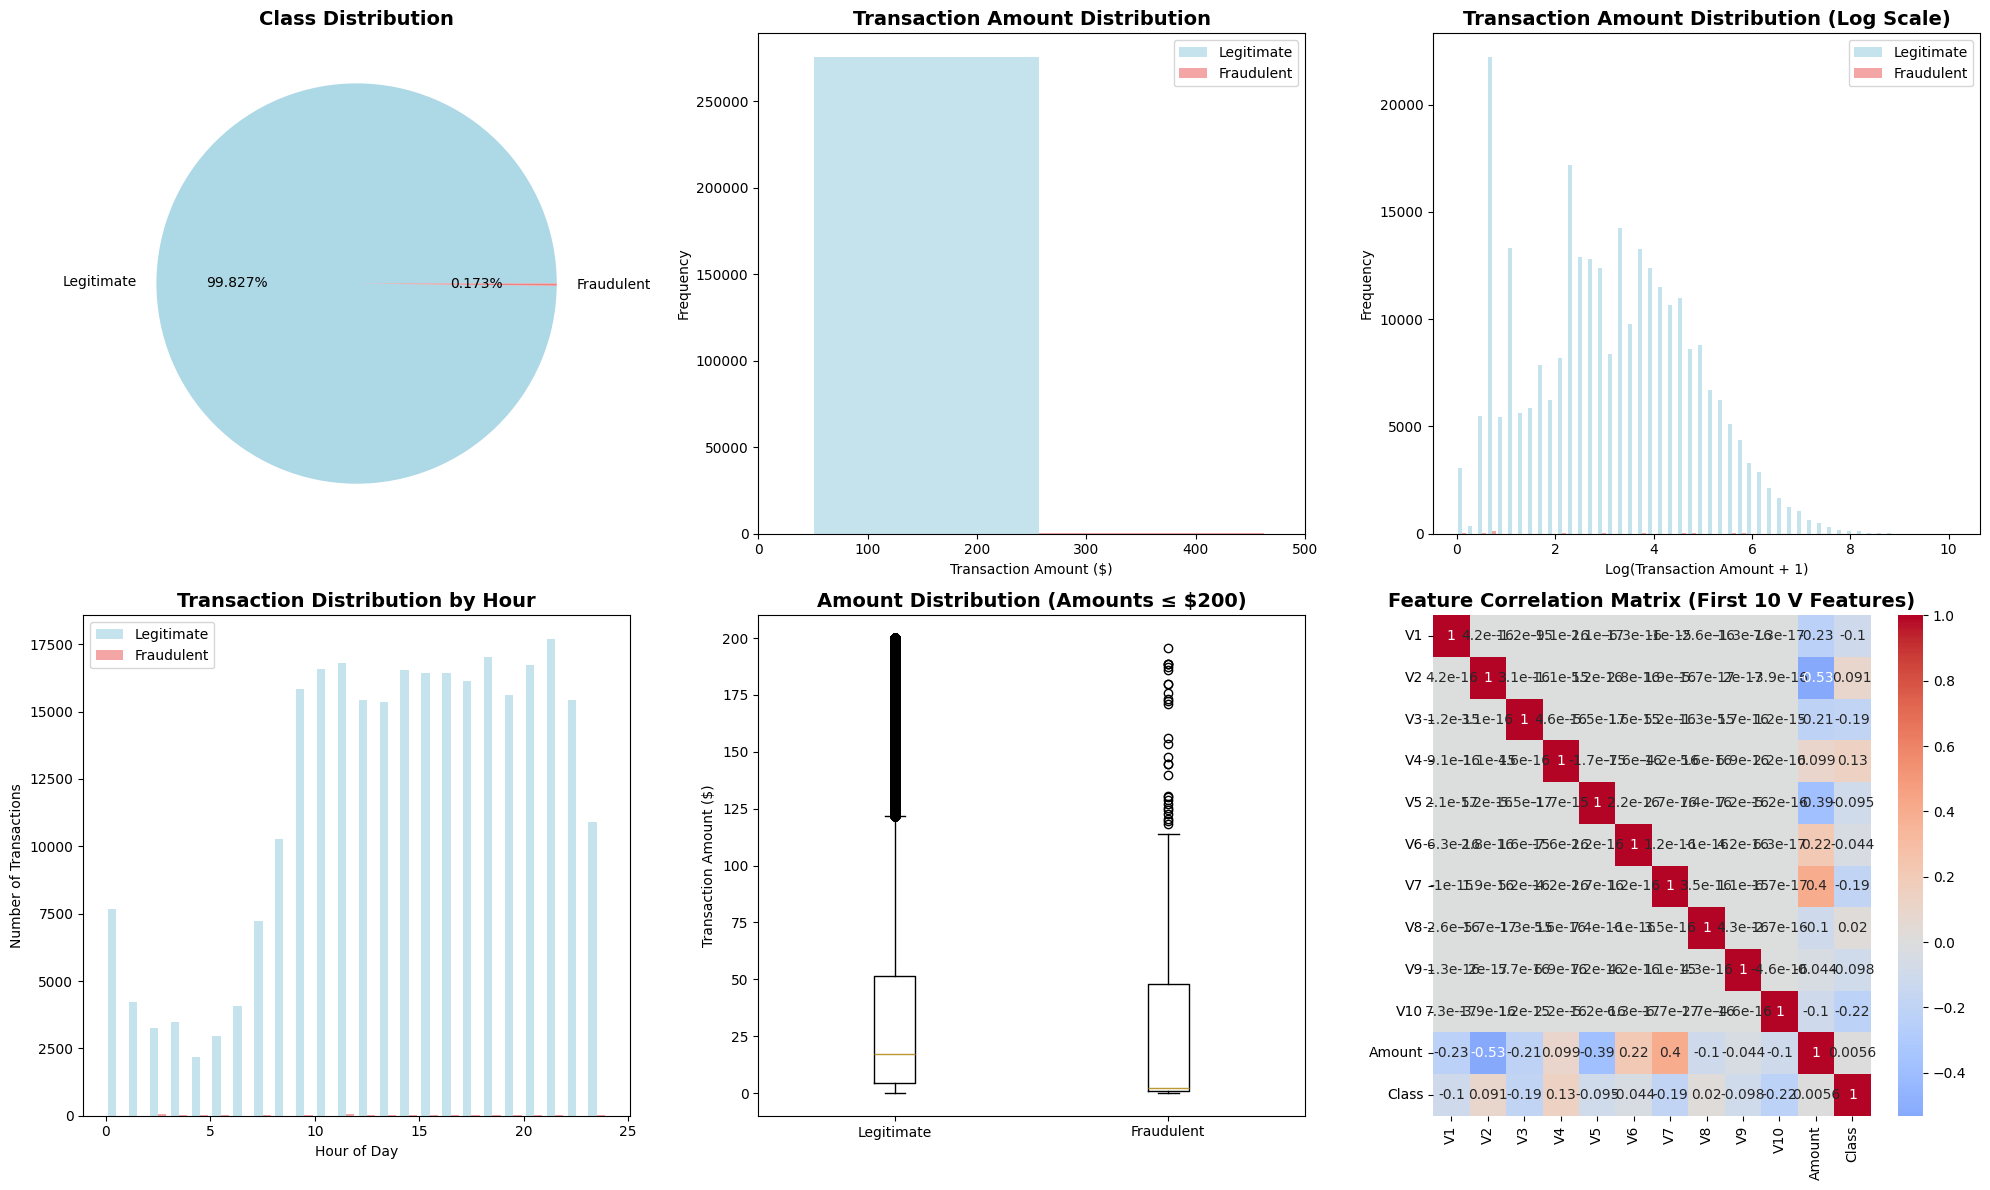

=== INTERESTING OBSERVATIONS ===
• Average fraudulent transaction: $122.21
• Average legitimate transaction: $88.29
• Fraudulent transactions are on average 1.38x smaller
• Amount outliers: 31904 (11.20%)
• Maximum transaction amount: $25,691.16


In [4]:
# Create comprehensive visualizations for data exploration
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Class distribution
axes[0, 0].pie(class_counts.values, labels=['Legitimate', 'Fraudulent'], 
               autopct='%1.3f%%', colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')

# 2. Transaction amounts distribution
axes[0, 1].hist([legitimate_amounts, fraudulent_amounts], bins=50, alpha=0.7,
                label=['Legitimate', 'Fraudulent'], color=['lightblue', 'lightcoral'])
axes[0, 1].set_xlabel('Transaction Amount ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 500)  # Focus on lower amounts for better visibility

# 3. Transaction amounts (log scale)
axes[0, 2].hist([np.log1p(legitimate_amounts), np.log1p(fraudulent_amounts)], 
                bins=50, alpha=0.7, label=['Legitimate', 'Fraudulent'], 
                color=['lightblue', 'lightcoral'])
axes[0, 2].set_xlabel('Log(Transaction Amount + 1)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Transaction Amount Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 2].legend()

# 4. Time distribution of transactions
df['Hour'] = (df['Time'] / 3600) % 24
legitimate_times = df[df['Class'] == 0]['Hour']
fraudulent_times = df[df['Class'] == 1]['Hour']

axes[1, 0].hist([legitimate_times, fraudulent_times], bins=24, alpha=0.7,
                label=['Legitimate', 'Fraudulent'], color=['lightblue', 'lightcoral'])
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].set_title('Transaction Distribution by Hour', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# 5. Amount comparison boxplot
amount_data = [legitimate_amounts[legitimate_amounts <= 200], 
               fraudulent_amounts[fraudulent_amounts <= 200]]
axes[1, 1].boxplot(amount_data, labels=['Legitimate', 'Fraudulent'])
axes[1, 1].set_ylabel('Transaction Amount ($)')
axes[1, 1].set_title('Amount Distribution (Amounts ≤ $200)', fontsize=14, fontweight='bold')

# 6. Correlation heatmap for first 10 V features
correlation_matrix = df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Amount', 'Class']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Matrix (First 10 V Features)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print some interesting statistics
print("=== INTERESTING OBSERVATIONS ===")
print(f"• Average fraudulent transaction: ${fraudulent_amounts.mean():.2f}")
print(f"• Average legitimate transaction: ${legitimate_amounts.mean():.2f}")
print(f"• Fraudulent transactions are on average {fraudulent_amounts.mean()/legitimate_amounts.mean():.2f}x smaller")

# Check for outliers in Amount
q75, q25 = np.percentile(df['Amount'], [75, 25])
iqr = q75 - q25
lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr
outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]
print(f"• Amount outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"• Maximum transaction amount: ${df['Amount'].max():,.2f}")


## 2. Data Preprocessing

I'll prepare the data for anomaly detection by scaling features and creating additional time-based features. Since most algorithms are unsupervised, I'll primarily use the legitimate transactions for training.


In [5]:
# Create additional time-based features
print("=== FEATURE ENGINEERING ===")

# Add time-based features
df['Hour'] = (df['Time'] / 3600) % 24
df['Day'] = (df['Time'] / (24 * 3600)) % 7  # Assuming 7-day cycle

# Create cyclical features for time (better for ML algorithms)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 7)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 7)

# Log transform the amount (handle zeros by adding 1)
df['Log_Amount'] = np.log1p(df['Amount'])

print(f"Added time-based features. New shape: {df.shape}")

# Select features for anomaly detection
# Exclude original Time since I created better time features
# V1-V28 are already PCA-transformed features (good for anomaly detection)
feature_columns = [f'V{i}' for i in range(1, 29)] + [
    'Log_Amount', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos'
]

print(f"Selected {len(feature_columns)} features for anomaly detection")
print(f"Features: {feature_columns[:5]}... (showing first 5)")

# Prepare feature matrix
X = df[feature_columns].copy()
y = df['Class'].copy()

print(f"\n=== DATA PREPARATION ===")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features info:")
print(X.info())


=== FEATURE ENGINEERING ===
Added time-based features. New shape: (284807, 38)
Selected 33 features for anomaly detection
Features: ['V1', 'V2', 'V3', 'V4', 'V5']... (showing first 5)

=== DATA PREPARATION ===
Feature matrix shape: (284807, 33)
Target vector shape: (284807,)
Features info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   V1          284807 non-null  float64
 1   V2          284807 non-null  float64
 2   V3          284807 non-null  float64
 3   V4          284807 non-null  float64
 4   V5          284807 non-null  float64
 5   V6          284807 non-null  float64
 6   V7          284807 non-null  float64
 7   V8          284807 non-null  float64
 8   V9          284807 non-null  float64
 9   V10         284807 non-null  float64
 10  V11         284807 non-null  float64
 11  V12         284807 non-null  float64
 12  V13  

In [6]:
# Split data for training and testing
# For anomaly detection, I'll use different strategies for different algorithms
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"=== DATA SPLITTING ===")
print(f"Training set: {X_train.shape[0]:,} transactions")
print(f"Testing set: {X_test.shape[0]:,} transactions")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Testing fraud rate: {y_test.mean():.4f}")

# For unsupervised anomaly detection, create a "clean" training set with only normal transactions
X_train_normal = X_train[y_train == 0].copy()
print(f"Normal training set: {X_train_normal.shape[0]:,} transactions (fraud-free)")

# Scale the features
print(f"\n=== FEATURE SCALING ===")

# Use RobustScaler as it's less sensitive to outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_normal_scaled = scaler.transform(X_train_normal)

print(f"Features scaled using RobustScaler")
print(f"Training set (scaled) shape: {X_train_scaled.shape}")
print(f"Test set (scaled) shape: {X_test_scaled.shape}")
print(f"Normal training set (scaled) shape: {X_train_normal_scaled.shape}")

# Convert back to DataFrames for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
X_train_normal_scaled_df = pd.DataFrame(X_train_normal_scaled, columns=feature_columns, index=X_train_normal.index)

print(f"\n=== SCALING VERIFICATION ===")
print("Before scaling (training set):")
print(f"  Mean: {X_train.mean().mean():.3f}")
print(f"  Std: {X_train.std().mean():.3f}")
print("After scaling (training set):")
print(f"  Mean: {X_train_scaled_df.mean().mean():.3f}")
print(f"  Std: {X_train_scaled_df.std().mean():.3f}")


=== DATA SPLITTING ===
Training set: 227,845 transactions
Testing set: 56,962 transactions
Training fraud rate: 0.0017
Testing fraud rate: 0.0017
Normal training set: 227,451 transactions (fraud-free)

=== FEATURE SCALING ===
Features scaled using RobustScaler
Training set (scaled) shape: (227845, 33)
Test set (scaled) shape: (56962, 33)
Normal training set (scaled) shape: (227451, 33)

=== SCALING VERIFICATION ===
Before scaling (training set):
  Mean: 0.120
  Std: 0.939
After scaling (training set):
  Mean: 0.006
  Std: 1.091


## 3. Anomaly Detection Algorithms

I'll implement and compare multiple anomaly detection algorithms. Each has different strengths and assumptions about the nature of anomalies.


In [7]:
# Initialize anomaly detection algorithms
print("=== INITIALIZING ANOMALY DETECTION ALGORITHMS ===")

# Calculate contamination rate (percentage of fraud in training set)
contamination_rate = y_train.mean()
print(f"Contamination rate: {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")

# Define algorithms with different approaches
algorithms = {
    'Isolation Forest': IsolationForest(
        contamination=contamination_rate,
        random_state=42,
        n_estimators=100
    ),
    'One-Class SVM': OneClassSVM(
        nu=contamination_rate,  # nu should be close to contamination rate
        kernel='rbf',
        gamma='scale'
    ),
    'Local Outlier Factor': LocalOutlierFactor(
        contamination=contamination_rate,
        n_neighbors=20
    ),
    'Elliptic Envelope': EllipticEnvelope(
        contamination=contamination_rate,
        random_state=42
    )
}

print(f"Initialized {len(algorithms)} algorithms:")
for name, algo in algorithms.items():
    print(f"  • {name}")

# Store results for comparison
results = {}

print(f"\n=== TRAINING AND EVALUATING ALGORITHMS ===")

for name, algorithm in algorithms.items():
    print(f"\n--- {name} ---")
    
    try:
        # Train on normal transactions only (unsupervised approach)
        if name == 'Local Outlier Factor':
            # LOF requires fit_predict (doesn't have separate fit and predict)
            # So I'll train on a sample of training data and predict on test data
            sample_size = min(10000, len(X_train_normal_scaled))  # Limit for performance
            sample_indices = np.random.choice(len(X_train_normal_scaled), sample_size, replace=False)
            X_sample = X_train_normal_scaled[sample_indices]
            
            # For LOF, I'll fit on combined train+test to get outlier scores
            X_combined = np.vstack([X_train_scaled, X_test_scaled])
            y_combined = np.hstack([y_train, y_test])
            
            lof_predictions = algorithm.fit_predict(X_combined)
            
            # Extract test predictions
            train_size = len(X_train_scaled)
            test_predictions = lof_predictions[train_size:]
            
            # Convert LOF output (-1 for outliers, 1 for inliers) to 0/1 format
            test_predictions = (test_predictions == -1).astype(int)
            
            # Get anomaly scores (negative values indicate anomalies)
            test_scores = -algorithm.negative_outlier_factor_[train_size:]
            
        else:
            # Standard fit on normal transactions, predict on test set
            print(f"  Training on {len(X_train_normal_scaled):,} normal transactions...")
            algorithm.fit(X_train_normal_scaled)
            
            print(f"  Predicting on {len(X_test_scaled):,} test transactions...")
            test_predictions = algorithm.predict(X_test_scaled)
            
            # Convert predictions to 0/1 format (anomaly detection algorithms use -1/1)
            test_predictions = (test_predictions == -1).astype(int)
            
            # Get anomaly scores
            if hasattr(algorithm, 'score_samples'):
                test_scores = -algorithm.score_samples(X_test_scaled)  # Negative for anomaly scores
            elif hasattr(algorithm, 'decision_function'):
                test_scores = -algorithm.decision_function(X_test_scaled)  # Negative for anomaly scores
            else:
                test_scores = test_predictions.astype(float)  # Use predictions as scores
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, test_predictions)
        precision = precision_score(y_test, test_predictions, zero_division=0)
        recall = recall_score(y_test, test_predictions, zero_division=0)
        f1 = f1_score(y_test, test_predictions, zero_division=0)
        
        # Calculate AUC if possible
        try:
            auc = roc_auc_score(y_test, test_scores)
            avg_precision = average_precision_score(y_test, test_scores)
        except:
            auc = np.nan
            avg_precision = np.nan
        
        # Store results
        results[name] = {
            'algorithm': algorithm,
            'predictions': test_predictions,
            'scores': test_scores,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'avg_precision': avg_precision
        }
        
        print(f"  ✓ Accuracy: {accuracy:.4f}")
        print(f"  ✓ Precision: {precision:.4f}")
        print(f"  ✓ Recall: {recall:.4f}")
        print(f"  ✓ F1-Score: {f1:.4f}")
        print(f"  ✓ AUC: {auc:.4f}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        results[name] = None

print(f"\n=== ALGORITHM TRAINING COMPLETE ===")
successful_algorithms = [name for name, result in results.items() if result is not None]
print(f"Successfully trained {len(successful_algorithms)} algorithms: {successful_algorithms}")


=== INITIALIZING ANOMALY DETECTION ALGORITHMS ===
Contamination rate: 0.0017 (0.17%)
Initialized 4 algorithms:
  • Isolation Forest
  • One-Class SVM
  • Local Outlier Factor
  • Elliptic Envelope

=== TRAINING AND EVALUATING ALGORITHMS ===

--- Isolation Forest ---
  Training on 227,451 normal transactions...
  Predicting on 56,962 test transactions...
  ✓ Accuracy: 0.9969
  ✓ Precision: 0.2121
  ✓ Recall: 0.2857
  ✓ F1-Score: 0.2435
  ✓ AUC: 0.9539

--- One-Class SVM ---
  Training on 227,451 normal transactions...
  Predicting on 56,962 test transactions...
  ✓ Accuracy: 0.9880
  ✓ Precision: 0.1077
  ✓ Recall: 0.8163
  ✓ F1-Score: 0.1902
  ✓ AUC: 0.9597

--- Local Outlier Factor ---
  ✓ Accuracy: 0.9966
  ✓ Precision: 0.0000
  ✓ Recall: 0.0000
  ✓ F1-Score: 0.0000
  ✓ AUC: 0.5792

--- Elliptic Envelope ---
  Training on 227,451 normal transactions...
  Predicting on 56,962 test transactions...
  ✓ Accuracy: 0.9977
  ✓ Precision: 0.4167
  ✓ Recall: 0.8163
  ✓ F1-Score: 0.5517
  ✓ AU